In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [3]:
# Load the CSV file distances (Data aggregated for nucleos)
file_path = "C:/Users/vehico/Documents/Thesis/Distance-project/aggregated_hospital_distances_transit_ROMA.csv"
df = pd.read_csv(file_path)
df.head(5)

,Comune,Nucleo_ID,Popolazione,mean_km,St.Dv_km,mean_min,St.Dv_min,match_ratio
0,AFFILE,5800110001,1297.0,9.258,NaN,21.700000,NaN,1/1
1,AFFILE,5800126602,20.0,5.570,NaN,16.933333,NaN,1/1
2,AFFILE,5800126701,28.0,11.222,NaN,55.000000,NaN,1/1
3,AGOSTA,5800210001,1010.0,9.827,NaN,32.900000,NaN,1/1
4,AGOSTA,5800210002,389.0,7.211,NaN,29.733333,NaN,1/1


In [5]:
# Function to check whether a match_ratio is full (e.g. “1/1”)
def is_full_match(ratio):
    try:
        num, den = map(int, ratio.split('/'))
        if num == 0:
            return True
        else:
            return False
        
    except:
        return False  # Just in case there's any NaN or not real value

In [6]:
# Apply the function
df["full"] = df["match_ratio"].apply(is_full_match)

In [7]:
# Filters out urban cores that do NOT have complete matches
nuclei_incompleti = df[df["full"]]
nuclei_incompleti

,Comune,Nucleo_ID,Popolazione,mean_km,St.Dv_km,mean_min,St.Dv_min,match_ratio,full
69,CAPENA,5801820001,888.0,NaN,NaN,NaN,NaN,0/0,True
108,CERVARA DI ROMA,5802820001,82.0,NaN,NaN,NaN,NaN,0/0,True
129,CERVETERI,5802926612,30.0,NaN,NaN,NaN,NaN,0/0,True
271,MORLUPO,5806820003,75.0,NaN,NaN,NaN,NaN,0/0,True
424,TREVIGNANO ROMANO,5810726610,13.0,NaN,NaN,NaN,NaN,0/0,True


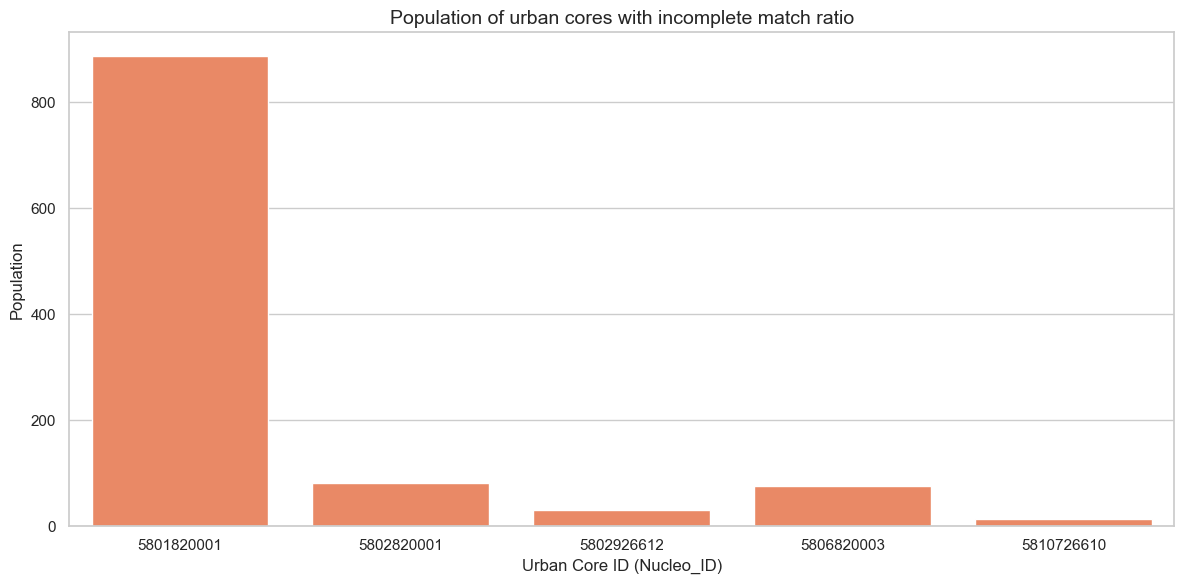

In [8]:
# Set plot style
sns.set(style="whitegrid")

# Sort by population descending
nuclei_incompleti_sorted = nuclei_incompleti.sort_values(by="Popolazione", ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=nuclei_incompleti_sorted,
    x="Nucleo_ID",
    y="Popolazione",
    color="coral"
)

plt.title("Population of urban cores with incomplete match ratio", fontsize=14)
plt.xlabel("Urban Core ID (Nucleo_ID)", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.tight_layout()
plt.show()

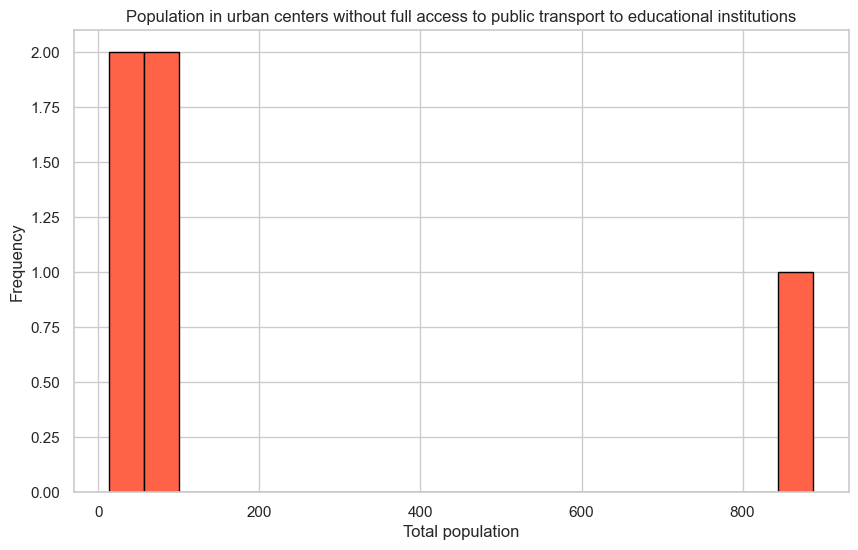

In [9]:
# Histogram of total population of the urban centers without public transport
plt.figure(figsize=(10, 6))
plt.hist(nuclei_incompleti["Popolazione"], bins=20, color='tomato', edgecolor='black')
plt.title("Population in urban centers without full access to public transport to educational institutions")
plt.xlabel("Total population")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [10]:
# Load the total population per municipality
df_comuni = pd.read_csv("C:/Users/vehico/Documents/Thesis/Distance-project/Raw_data_processing/Raw_data/DCIS_POPRES1_12022025124521891.csv")

# Clean column and adjust columns names
df_comuni.columns = df_comuni.columns.str.strip().str.replace('"', '')
df_comuni['Territorio'] = df_comuni['Territorio'].str.upper()

# Rename and keep only necessary columns
df_comuni = df_comuni.rename(columns={
    "Territorio": "Comune",
    "Value": "Popolazione_totale"
})[["Comune", "Popolazione_totale"]]

In [11]:
# Aggregate population with NA per Comune
pop_na_per_comune = nuclei_incompleti.groupby("Comune")["Popolazione"].sum().reset_index()
pop_na_per_comune = pop_na_per_comune.rename(columns={"Popolazione": "Popolazione_NA"})

In [12]:
# Merge with total population
df_risultato = pd.merge(df_comuni, pop_na_per_comune, on="Comune", how="left")
df_risultato["Popolazione_NA"] = df_risultato["Popolazione_NA"].fillna(0)

In [13]:
# Calculate the percentage
df_risultato["Perc_NA"] = (df_risultato["Popolazione_NA"] / df_risultato["Popolazione_totale"]) * 100

In [14]:
# Show the result
df_risultato = df_risultato.sort_values("Perc_NA", ascending=False)
df_risultato[["Comune", "Perc_NA", "Popolazione_NA", "Popolazione_totale"]].head(4)

,Comune,Perc_NA,Popolazione_NA,Popolazione_totale
93,CERVARA DI ROMA,17.672414,82.0,464
56,CAPENA,8.180562,888.0,10855
209,MORLUPO,0.884851,75.0,8476
337,TREVIGNANO ROMANO,0.223868,13.0,5807


In [15]:
# Filter only municipalities with percentage other than 0
df_risultato_filt = df_risultato[df_risultato["Perc_NA"] > 0]

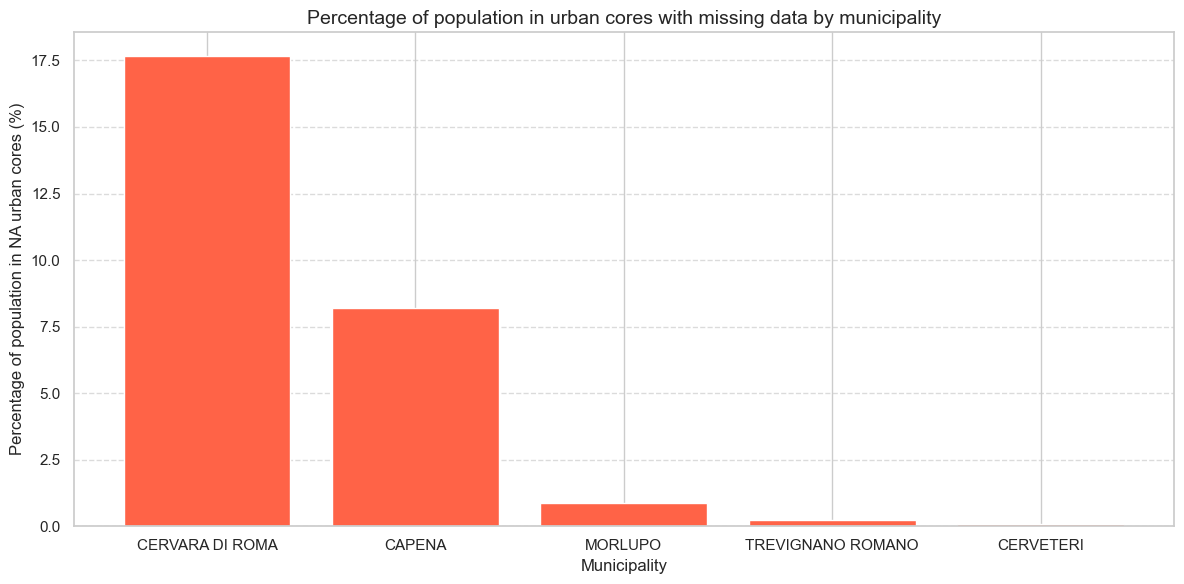

In [16]:
# Graph the weighted percentage by municipality
plt.figure(figsize=(12, 6))
bars = plt.bar(df_risultato_filt["Comune"], df_risultato_filt["Perc_NA"], color="tomato")
plt.title("Percentage of population in urban cores with missing data by municipality", fontsize=14)
plt.xlabel("Municipality", fontsize=12)
plt.ylabel("Percentage of population in NA urban cores (%)", fontsize=12)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Comparison of population of nuclei with and without NA

In [17]:
# Mann-Whitney U test
stat, p_value = stats.mannwhitneyu(nuclei_incompleti['Popolazione'], df['Popolazione'])
print(f'Mann-Whitney U test: p-value = {p_value}')

Mann-Whitney U test: p-value = 0.19045230642966493


In [18]:
# Medians of the populations of the nuclei with and without NA

median_na = nuclei_incompleti['Popolazione'].median()
print(f'Median number of population cores with NA: {median_na}')

median_no_na = df['Popolazione'].median()
print(f'Median number of population cores without NA: {median_no_na}')

Median number of population cores with NA: 75.0
Median number of population cores without NA: 151.0


In [19]:
# Kolmogorov-Smirnov test
ks_stat, ks_p_value = stats.ks_2samp(nuclei_incompleti['Popolazione'], df['Popolazione'])
print(f'Kolmogorov-Smirnov test = {ks_p_value}')

Kolmogorov-Smirnov test = 0.2234196349739572


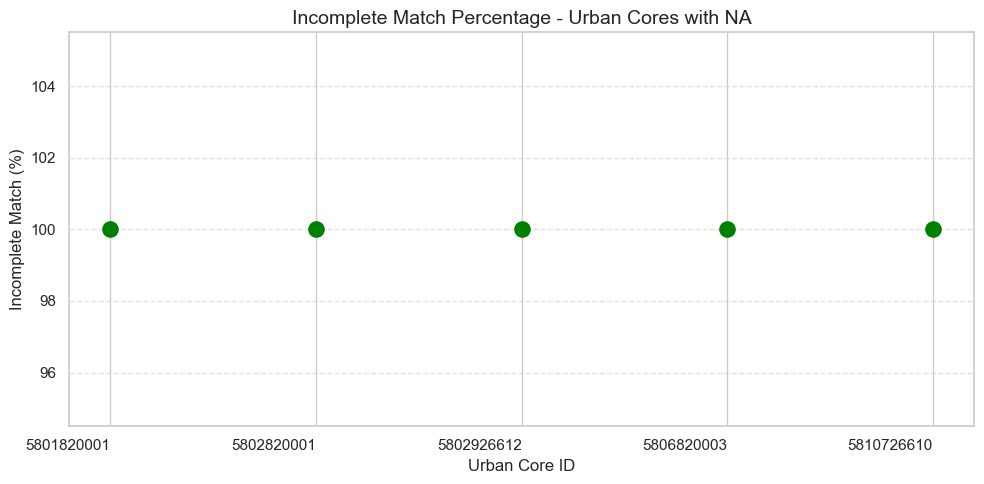

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Funzione per estrarre il numeratore e denominatore e calcolare la % incompleta
def estrai_percentuale_incompleta(ratio):
    if pd.isna(ratio) or "/" not in ratio:
        return 100  # Se manca del tutto lo consideriamo completamente incompleto
    num, denom = ratio.split("/")
    num, denom = int(num), int(denom)
    if denom == 0:
        return 100
    return 100 * (1 - num / denom)

nuclei_incompleti = nuclei_incompleti.copy()

# Applicare la funzione per ogni categoria
nuclei_incompleti["percent_incomplete"] = nuclei_incompleti["match_ratio"].apply(estrai_percentuale_incompleta)


# Aggiungi indice per l'asse X
nuclei_incompleti["index"] = range(len(nuclei_incompleti))


# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(nuclei_incompleti["index"], nuclei_incompleti["percent_incomplete"], label="Hospital", color="green", marker="o", s=120)

# Etichette asse X
ax.set_xticks(nuclei_incompleti["index"])
ax.set_xticklabels(nuclei_incompleti["Nucleo_ID"], ha="right")

# Titoli
ax.set_title("Incomplete Match Percentage - Urban Cores with NA", fontsize=14)
ax.set_xlabel("Urban Core ID", fontsize=12)
ax.set_ylabel("Incomplete Match (%)", fontsize=12)

plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# Trying to impute different values for NaN

In [30]:
def imputazione_tempi_salute(df, lamma):
    df = df.copy()
    col_target = "mean_min"
    col_output = f"mean_min_lambda_{lamma}"
    col_flag = "full"   # Supponiamo che tu abbia già un flag booleano che indica dove imputare

    df[col_output] = np.nan

    # Calcolo Tmax e proporzione p per Comune
    t_max_dict = df.groupby("Comune")[col_target].max().to_dict()
    p_dict = df.groupby("Comune")[col_target].apply(lambda x: x.notna().mean()).to_dict()

    for idx, row in df.iterrows():
        val = row[col_target]
        comune = row['Comune']
        nucleo = row.get('Nucleo_ID', 'N/A')
        flag = row.get(col_flag, False)

        if pd.isna(val):
            T_max = t_max_dict.get(comune, np.nan)
            p = p_dict.get(comune, 0)

            if not np.isnan(T_max) and p > 0 and flag:
                penalizzazione = 1.5
                imputato = T_max * (1 - p) * lamma * penalizzazione + T_max * p
                df.at[idx, col_output] = imputato
        else:
            df.at[idx, col_output] = val

    return df[[col_output]]  # Restituisce solo la colonna imputata

# === Wrapper per applicare tutti i lambda ===
def wrapper_imputazione_salute(df, lambda_values):
    risultati = pd.DataFrame(index=df.index)

    for lamma in lambda_values:
        risultati[f"mean_min_lambda_{lamma}"] = imputazione_tempi_salute(df, lamma)

    return risultati

In [31]:
lambda_values = [1.1, 1.25, 1.5, 1.75, 2.0]


df_risultati = wrapper_imputazione_salute(df, lambda_values)


mean_min_lambda_ = [f"mean_min_lambda_{l}" for l in lambda_values]
df_risultati = df_risultati[
    df_risultati[mean_min_lambda_].diff(axis=1).iloc[:, -1] != 0
]

df_risultati.head()

,mean_min_lambda_1.1,mean_min_lambda_1.25,mean_min_lambda_1.5,mean_min_lambda_1.75,mean_min_lambda_2.0
69,212.706429,218.962500,229.389286,239.816071,250.242857
108,126.953571,130.687500,136.910714,143.133929,149.357143
129,278.217000,280.657500,284.725000,288.792500,292.860000
271,162.641061,165.782197,171.017424,176.252652,181.487879
424,105.364000,107.590000,111.300000,115.010000,118.720000


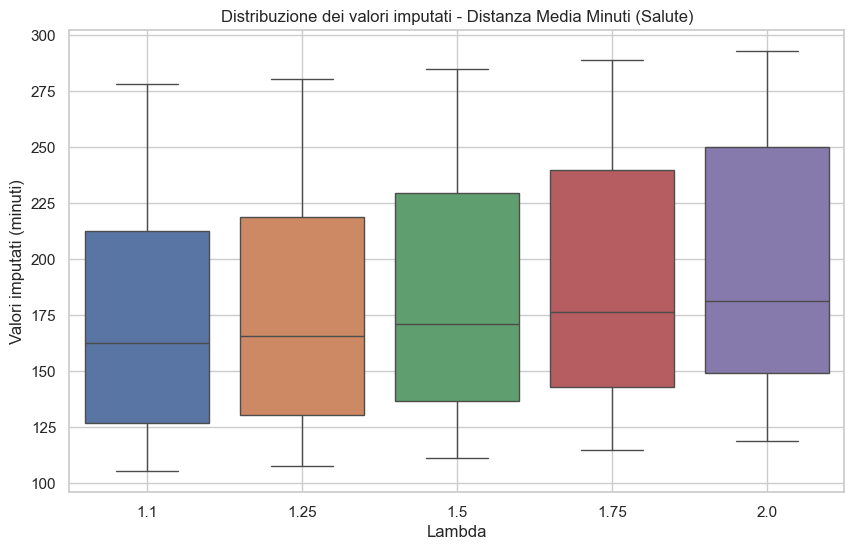

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtra solo le colonne dei lambda
lambda_cols = [col for col in df_risultati.columns if col.startswith("mean_min_lambda")]

# Creiamo il DataFrame solo con i valori imputati
df_lambda = df_risultati[lambda_cols]

# Boxplot per i valori imputati (Salute)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_lambda)

plt.title("Distribuzione dei valori imputati - Distanza Media Minuti (Salute)")
plt.xlabel("Lambda")
plt.ylabel("Valori imputati (minuti)")

# Etichette sull'asse X con i valori di lambda
plt.xticks(ticks=range(len(lambda_cols)), labels=[col.split('_')[-1] for col in lambda_cols])

plt.grid(True)
plt.show()

In [34]:
def calcola_media_ponderata_municipio_salute(df_risultati, df_info_base):
    # Prendi tutte le colonne che iniziano con 'mean_min_lambda'
    lambda_cols = [col for col in df_risultati.columns if col.startswith("mean_min_lambda")]

    # Unisci info base (Comune, Nucleo_ID, Popolazione) con i risultati imputati
    df_merge = pd.concat([
        df_info_base[['Nucleo_ID', 'Comune', 'Popolazione']],
        df_risultati[lambda_cols]
    ], axis=1)

    # Rimuovi eventuali righe senza popolazione
    df_merge = df_merge.dropna(subset=['Popolazione'])

    media_ponderata = {}
    for col in lambda_cols:
        def media(gruppo):
            gruppo_validi = gruppo.dropna(subset=[col])
            if len(gruppo_validi) == 0:
                return np.nan
            return np.average(gruppo_validi[col], weights=gruppo_validi["Popolazione"])

        grouped = df_merge.groupby("Comune").apply(media)
        media_ponderata[col] = grouped

    df_media_ponderata = pd.DataFrame(media_ponderata).reset_index()
    return df_media_ponderata

In [35]:
df_media = calcola_media_ponderata_municipio_salute(df_risultati, df)
df_media_filtrato = df_media[df_media.drop(columns="Comune").notna().any(axis=1)]
df_media_filtrato

C:\Users\vehico\AppData\Local\Temp\ipykernel_3960\1975524620.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_merge.groupby("Comune").apply(media)
C:\Users\vehico\AppData\Local\Temp\ipykernel_3960\1975524620.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_merge.groupby("Comune").apply(media)
C:\Users\vehico\AppData\Local\Temp\ipykernel_3960\1975524620.py:22: DeprecationWar

,Comune,mean_min_lambda_1.1,mean_min_lambda_1.25,mean_min_lambda_1.5,mean_min_lambda_1.75,mean_min_lambda_2.0
16,CAPENA,212.706429,218.962500,229.389286,239.816071,250.242857
26,CERVARA DI ROMA,126.953571,130.687500,136.910714,143.133929,149.357143
27,CERVETERI,278.217000,280.657500,284.725000,288.792500,292.860000
65,MORLUPO,162.641061,165.782197,171.017424,176.252652,181.487879
101,TREVIGNANO ROMANO,105.364000,107.590000,111.300000,115.010000,118.720000


In [36]:
def crea_tabella_riassuntiva(df_base, df_risultati, lambda_target):
    """
    Crea una tabella riassuntiva per una certa categoria e valore di lambda.
    
    df_base: dataframe originale con colonne Comune, Nucleo_ID, Popolazione
    df_risultati: dataframe con colonne tipo SI_lambda_1.1, SP_lambda_1.25, ecc.
    categoria: es. "SI"
    lambda_target: es. 1.5
    """
    colonna_lambda = f"mean_min_lambda_{lambda_target}"

    # Step 1: merge tra info base e risultati
    df_merge = pd.concat([
    df_base[['Nucleo_ID', 'Comune', 'Popolazione']],
    df_risultati[colonna_lambda]
], axis=1)

    # Step 2: flag se il valore è imputato o meno
    df_merge['Imputato'] = df_merge[colonna_lambda].notna()

    # Step 3: calcolo per Comune
    grouped = df_merge.groupby('Comune').agg(
        Nuclei_totali=('Nucleo_ID', 'count'),
        Nuclei_imputati=('Imputato', 'sum'),
        Popolazione_totale=('Popolazione', 'sum')
    )

    grouped['%_Imputati'] = grouped['Nuclei_imputati'] / grouped['Nuclei_totali'] * 100

    # Step 4: media ponderata solo dove imputato
    def media_ponderata(gruppo):
        gruppo_validi = gruppo.dropna(subset=[colonna_lambda])
        if len(gruppo_validi) == 0:
            return np.nan
        return np.average(gruppo_validi[colonna_lambda], weights=gruppo_validi['Popolazione'])

    media_dict = df_merge.groupby('Comune').apply(media_ponderata).to_dict()
    grouped['Media_ponderata'] = grouped.index.map(media_dict)

    return grouped.reset_index()


In [37]:
df_riassunto = crea_tabella_riassuntiva(df, df_risultati, lambda_target=1.5)
df_riassunto_ = df_riassunto[df_riassunto['%_Imputati'] > 0]
df_riassunto.head(10)

C:\Users\vehico\AppData\Local\Temp\ipykernel_3960\2026331074.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  media_dict = df_merge.groupby('Comune').apply(media_ponderata).to_dict()


,Comune,Nuclei_totali,Nuclei_imputati,Popolazione_totale,%_Imputati,Media_ponderata
0,AFFILE,3,0,1345.0,0.0,NaN
1,AGOSTA,4,0,1588.0,0.0,NaN
2,ALBANO LAZIALE,8,0,38363.0,0.0,NaN
3,ALLUMIERE,2,0,3642.0,0.0,NaN
4,ANGUILLARA SABAZIA,11,0,17530.0,0.0,NaN
5,ANTICOLI CORRADO,1,0,794.0,0.0,NaN
6,ARCINAZZO ROMANO,2,0,1179.0,0.0,NaN
7,ARICCIA,3,0,17854.0,0.0,NaN
8,ARSOLI,1,0,1260.0,0.0,NaN
9,ARTENA,6,0,12905.0,0.0,NaN


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supponiamo che df_media_salute sia il DataFrame ottenuto prima
# Contiene colonne: Comune, mean_min_lambda_1.1, mean_min_lambda_1.25, ..., mean_min_lambda_2.0

# Convertiamo il DataFrame in formato "long" con melt
df_melted = df_risultato.melt(
    id_vars=['Comune'],
    var_name='Lambda',
    value_name='Imputed Travel Time (min)'
)

# Estrai il valore numerico di lambda
df_melted['Lambda'] = df_melted['Lambda'].str.extract(r'lambda_([\d.]+)').astype(float)

# Filtra solo λ = 1.5
df_lambda15 = df_melted[df_melted['Lambda'] == 1.5]

# Rimuovi eventuali valori NaN
df_lambda15_filtrato = df_lambda15[df_lambda15['Imputed Travel Time (min)'].notna()]

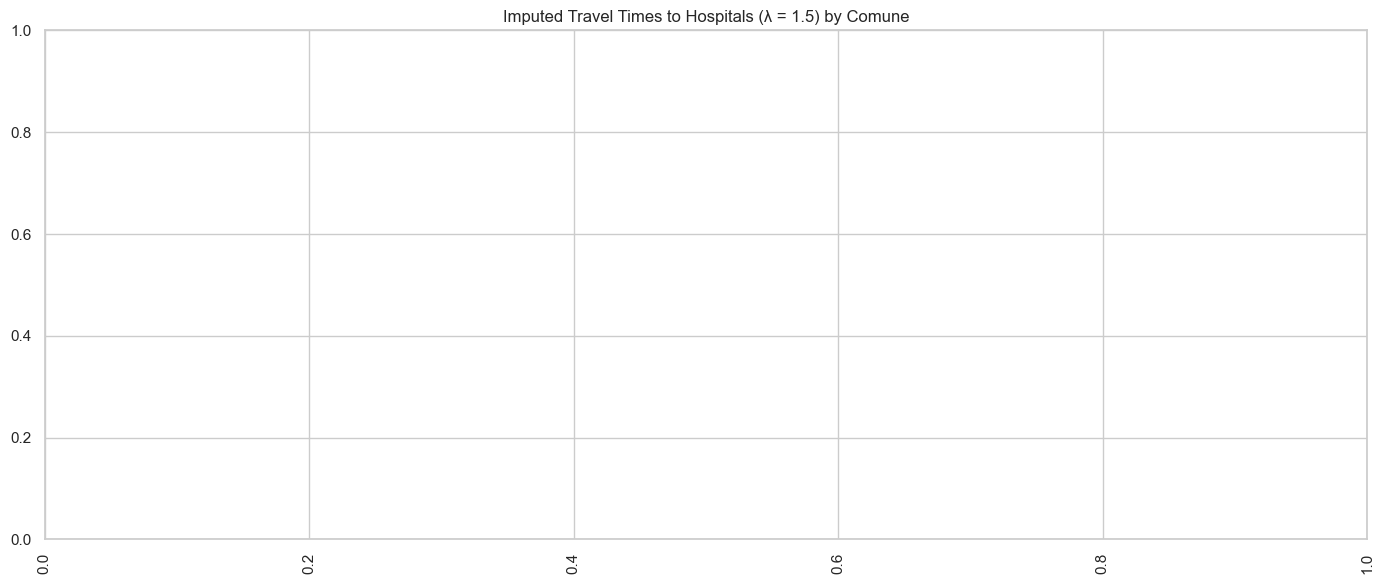

In [40]:
# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df_lambda15_filtrato, 
            x='Comune', 
            y='Imputed Travel Time (min)', 
            color='skyblue')

plt.title('Imputed Travel Times to Hospitals (λ = 1.5) by Comune')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()